# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings (not recommended)
import numpy as np
import calendar
import matplotlib.ticker as mticker

In [2]:
def add_bar_annotations(ax, offset=8):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, offset),  # Vertical offset
                    textcoords='offset points',
                    fontweight='bold')

# Data collection and Exploration

In [3]:
reviews = pd.read_csv("/kaggle/input/chatgpt-reviews-daily-updated/chatgpt_reviews.csv")


In [4]:
reviews.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,8103ca13-896b-4f2f-a6d0-5e0acbcf91ef,Somto Okechi,this is super intelligent ...you should try it,3,0,1.2024.131,2024-05-21 23:04:10,1.2024.131
1,106dc1ff-394a-4154-a16d-edfb2462c5a7,Felipe Sandoval,Me cambio la vida el asistente,5,0,NaN,2024-05-21 23:01:54,NaN
2,f65167ae-a7d3-48d2-b708-f3506018763a,Isaiah,it helped me so much you need to get it!!!,5,0,1.2024.131,2024-05-21 23:01:51,1.2024.131
3,a1b0f9df-9a31-4880-9838-6692d379c889,ReX MEDIA STUDIOX,Great 👌,5,0,1.2024.131,2024-05-21 23:00:24,1.2024.131
4,8c159eba-cce9-4cff-84af-7fae1024cdf8,jessica lyn,"Careful, you can't change the model so it deci...",1,0,1.2024.131,2024-05-21 22:53:28,1.2024.131


In [5]:
print("Total enteries : ",reviews.shape[0]) 
print("Total attributes : ",reviews.shape[1]) 

Total enteries :  122962
Total attributes :  8


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122962 entries, 0 to 122961
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              122962 non-null  object
 1   userName              122961 non-null  object
 2   content               122958 non-null  object
 3   score                 122962 non-null  int64 
 4   thumbsUpCount         122962 non-null  int64 
 5   reviewCreatedVersion  112500 non-null  object
 6   at                    122962 non-null  object
 7   appVersion            112500 non-null  object
dtypes: int64(2), object(6)
memory usage: 7.5+ MB


In [7]:
reviews.describe()

,score,thumbsUpCount
count,122962.000000,122962.000000
mean,4.497804,0.571746
std,1.089754,13.225767
min,1.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1193.000000


In [8]:
reviews.describe(include = ['object', 'category'])

,reviewId,userName,content,reviewCreatedVersion,at,appVersion
count,122962,122961,122958,112500,122962,112500
unique,120339,114464,82976,62,119390,62
top,eee4fae2-4e13-477c-bef9-c9e7a96e1ff6,Amit Kumar,good,1.2024.073,2024-05-12 08:41:31,1.2024.073
freq,6,23,3798,8310,12,8310


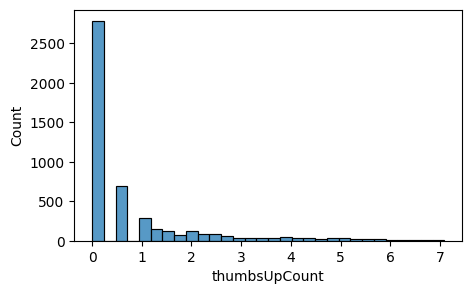

In [9]:
plt.figure(figsize=(5,3))
reviews_scores_log = np.log(reviews['thumbsUpCount'])
sns.histplot(x = reviews_scores_log, bins = 30)
plt.show()

`thumbsUpCount` shows positively skewed distribution means that most of the entries are 0.

# Data Cleaning

## Removing Duplicates

In [10]:
len(reviews[reviews.duplicated()])

2509

In [11]:
reviews.drop_duplicates(inplace = True)

## Dropping Irrelevant Columns

In [12]:
# Dropping reviewId, userName columns
reviews.drop(['reviewId', 'userName'], axis = 1, inplace = True)

# Also removing reviewCreatedVersion as this column is a duplicate of appVersion as shown in describe() above
reviews.drop('reviewCreatedVersion', axis = 1, inplace = True)

## Null Values

In [13]:
reviews.isna().sum()

content              4
score                0
thumbsUpCount        0
at                   0
appVersion       10332
dtype: int64

In [14]:
# Removing rows with null values in content as the null count is only 4
reviews.dropna(subset = ['content'], inplace = True)

In [15]:
modes_score = reviews.groupby('score')['appVersion'].agg(lambda x: x.mode().iloc[0]).to_dict()

# Imputing null values in appVersion based on the most frequent values in corresponding score subgroups
reviews['appVersion'].fillna(reviews['score'].map(modes_score), inplace = True)

In [16]:
reviews.isna().sum()

content          0
score            0
thumbsUpCount    0
at               0
appVersion       0
dtype: int64

## Data Types

In [17]:
reviews.dtypes

content          object
score             int64
thumbsUpCount     int64
at               object
appVersion       object
dtype: object

### Datatype of `score` from `int` to `category`

In [18]:
# reviews['score'] = reviews['score'].astype('category')
# reviews['score'] = reviews['score'].cat.reorder_categories(
#     new_categories = [1,2,3,4,5]
# )

### `at` column

#### renaming `at` to `Time`

In [19]:
reviews.rename(columns = {'at':'Time'}, inplace = True)

#### converting datatype of `Time` from `object` to `datetime`

In [20]:
reviews['Time'] = pd.to_datetime(reviews['Time'])

### `appVersion` Column

#### Converting data type from `object` to `categorical`

In [21]:
# reviews['appVersion'] = reviews['appVersion'].astype('category')

## Creating new Columns

### `Rating Type` from `content`

In [22]:
# Define new categories for Rating level column
ratings = ['Excellent', 'Good', 'Average', 'Fair', 'Poor']

#Define words for conditions
Excellent = "best|excellent|amazing|perfect|great|super|useful|wow|insane|exceptional|tremendous|professional|outstanding|loving|wonderful"
Good = "good|nice|easier|accha|smart|quick|helpful|fast"
Average = "update|satisfied|but|better"
Fair = "ok|slow|not|wrong|lack|weak|costly|can’t|don’t|doesnt|cannot|doesn’t"
Poor = "bugs|trash|worst|broken|fake|pathetic|careful|worse|bad|useless|stupid|inaccurate|poor|problem|terrible|error|incorrect|crash|garbage|failed|glitch|scam|😡|mistake"

# Defining conditions
conditions = [
    reviews['content'].str.lower().str.contains(Excellent),
    reviews['content'].str.lower().str.contains(Good),
    reviews['content'].str.lower().str.contains(Average),
    reviews['content'].str.lower().str.contains(Fair),
    reviews['content'].str.lower().str.contains(Poor)
]

# New Column
reviews['Rating type'] = np.select(conditions, ratings, default = 'Unspecified')
reviews['Rating type'] = reviews['Rating type'].astype('category')
reviews['Rating type'] = reviews['Rating type'].cat.reorder_categories(
    new_categories = ['Excellent', 'Good', 'Average', 'Fair', 'Poor', 'Unspecified'],
    ordered = True
)


In [23]:

reviews['content'].sample(1000)

53004                    Nice very very nice App I ever see
122266                                                🤷🏼‍♂️
114884                                            awesome 😎
119101                                              Amazing
3311                       very effective apps for learning
                                ...                        
67164                 Good its like loki at the end of time
87273                                     Highly convenient
512       after 4o update the app miss behaves refreshes...
71668                                    wow it really good
106943                                         very helpful
Name: content, Length: 1000, dtype: object

In [24]:
reviews.groupby('score')['content'].sample(1000, random_state = 2026)

99937                                                  Best
16476     I can't log in even though I got the latest ve...
73056     Go ahead. Use this if you enjoy delusion and b...
60205     I'm not happy about its access to personal dat...
63786     There is no justified reason for this app to n...
                                ...                        
45886                                good for every student
76046                                 we are best friends 😄
106055                                       wow kya ai hai
97466                                               Amazing
26502     This is easy to use and answers me immediately...
Name: content, Length: 5000, dtype: object

In [25]:
reviews['Rating type'].value_counts()

Rating type
Excellent      38430
Unspecified    36908
Good           34406
Average         4823
Fair            4006
Poor            1876
Name: count, dtype: int64

### Dropping `content` Column

In [26]:
reviews.drop('content', axis=1, inplace=True)

### Exctracting components from `Time`

#### `Month` Column

In [27]:
reviews['Month'] = reviews['Time'].dt.strftime('%b')
reviews['Month'] = reviews['Month'].astype('category')
reviews['Month'] = reviews['Month'].cat.set_categories(
    new_categories=list(calendar.month_abbr[1:]),
    ordered = True
)

### `Weekday` Column

In [28]:
reviews['Weekday'] = reviews['Time'].dt.strftime('%a')
reviews['Weekday'] = reviews['Weekday'].astype('category')
reviews['Weekday'] = reviews['Weekday'].cat.set_categories(
    new_categories=list(calendar.day_abbr),
    ordered = True
)

# Insights From Data

## How does the number of thumbs-up count vary with different review scores?

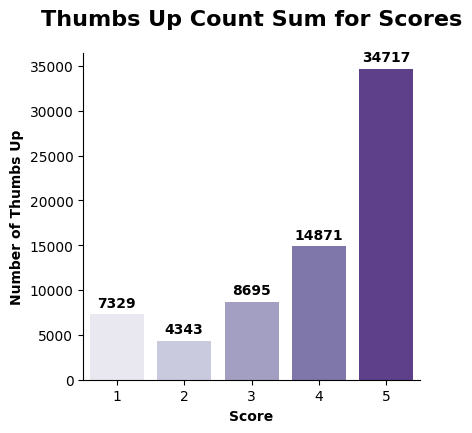

In [29]:
g = sns.catplot(data=reviews, x='score', y='thumbsUpCount', kind='bar', estimator='sum', ci=None, palette='Purples', height=4, aspect=1.1)

plt.title('Thumbs Up Count Sum for Scores', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Score', fontweight='bold')
plt.ylabel('Number of Thumbs Up', fontweight='bold')

ax = g.ax
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 8),  # 10 points vertical offset
                textcoords = 'offset points',
                fontweight = 'bold')

plt.show()

Above **barplot** indicates that:
- Reviews with a score of `5` had highest total number of thumbs up around `35000`.
- Conversely, reviews with score of 2 had lowest total number of thumbs up below `5000`.
- The rest are ranged around a sum between `7500` to `15000`. 

## What are the most common versions of the app mentioned in the reviews?

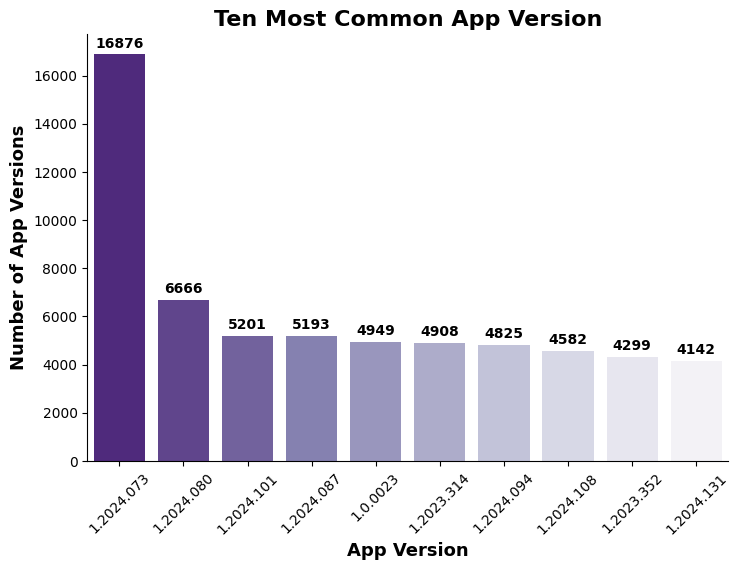

In [30]:
top_versions = reviews['appVersion'].value_counts().reset_index().head(10)

g = sns.catplot(data = top_versions , x = 'appVersion', y = 'count', kind = 'bar', aspect = 1.5, palette = 'Purples_r')
plt.title('Ten Most Common App Version', fontweight = 'bold', fontsize = 16)
plt.xlabel('App Version', fontweight = 'bold', fontsize = 13)
plt.ylabel('Number of App Versions', fontweight = 'bold', fontsize = 13)
plt.xticks(rotation = 45)
add_bar_annotations(g.ax)
plt.show()

Above **bar chart** shows the review counts of top ten versions, the details are:
- App Version `1.2024.073` is the most prevalent with around **16500** instances.
- The second most common version is `1.2024.080` with around **6600** instances.
- There is not significant change in the count of reviews of other app versions, they range between **5150** and **3900**.

## Is there any correlation between the review score and the App version?

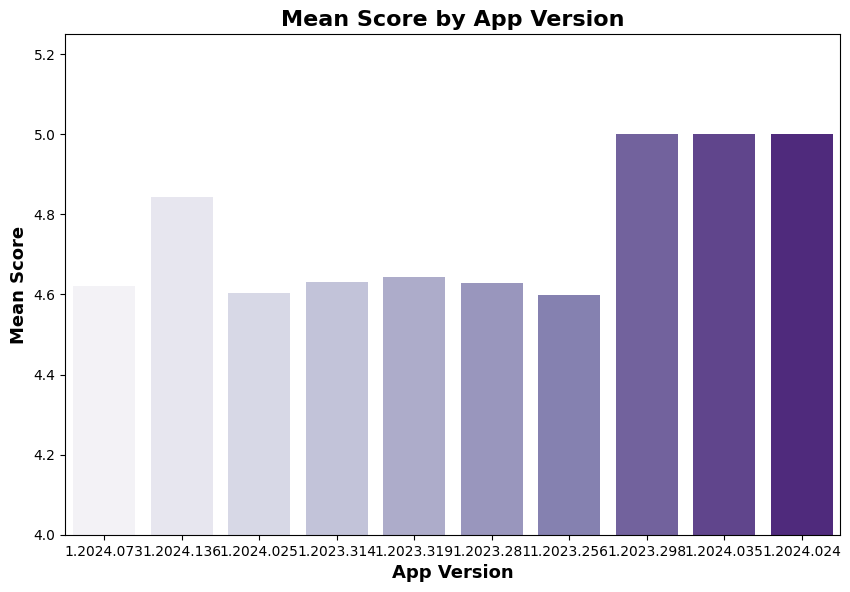

In [31]:
versions_by_mean_score = reviews.groupby('appVersion')['score'].mean().sort_values(ascending=False).head(10).reset_index()
top_app_version_reviews = reviews[reviews['appVersion'].isin(versions_by_mean_score['appVersion'])]

plt.figure(figsize=(10, 6.5))

sns.barplot(data = top_app_version_reviews, x = 'appVersion', y = 'score', ci = None, palette = 'Purples')
plt.title('Mean Score by App Version', fontweight = 'bold', fontsize = 16)
plt.xlabel('App Version', fontweight = 'bold', fontsize = 13)
plt.ylabel('Mean Score', fontweight = 'bold', fontsize = 13)
plt.ylim(4,5.25)
plt.show()

The **Bar chart** above reveals that:
- The top ten versions got a score ranging between **4.5** and **5**.
- App versions **1.2023.298, 1.2024.035 and 1.2024.024** got a mean review score of `5`.
- Remaining version received average score around **4.6**.

## What are the most common Rating types mentioned in the review content?

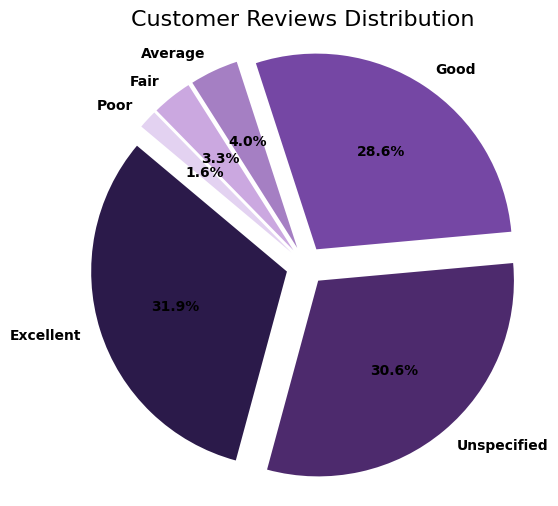

In [32]:
review_counts = reviews['Rating type'].value_counts(normalize=True)*100

Purples = ['#2B1A4A', '#4D2A6D', '#7547A4', '#A57FC3', '#CBA8E0', '#E3D2F1']
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # Update explode to match the length of review_counts.index

# Create a pie chart with exploding slices
plt.figure(figsize=(6, 6))
plt.pie(review_counts, labels=review_counts.index, autopct=lambda p: f'{p:.1f}%', startangle=140, colors=Purples, explode=explode, textprops={'fontweight': 'bold'})

# Customizing the plot
plt.title('Customer Reviews Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Show the plot
plt.show()

The **Pie chart** displays that:
- Most of the review content of about `32%` fall in the category of **Excellent**.
- However, a major percentage `(30.7%)` of reviews were **Unspecified**.
- Only `9%` of total reviews goes to **Average, fair and poor** review category. 

## Can we discern any monthly patterns in the frequency of reviews?

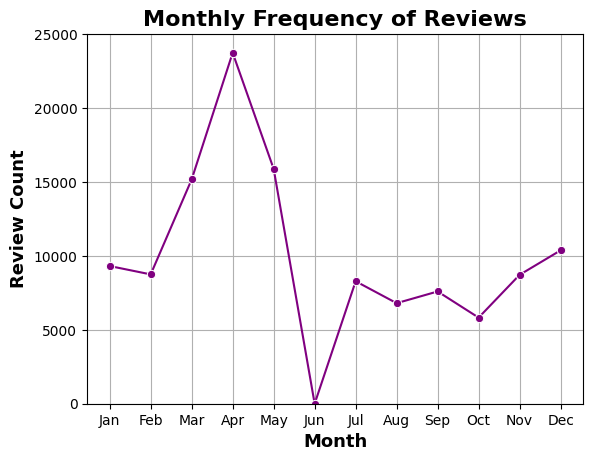

In [33]:
month_counts = reviews['Month'].value_counts(sort=False).reset_index()

sns.lineplot(data = month_counts, x = 'Month', y = 'count', marker='o', color = 'Purple')
plt.title('Monthly Frequency of Reviews',fontweight = 'bold', fontsize = 16)
plt.xlabel('Month', fontweight = 'bold', fontsize = 13) 
plt.ylabel('Review Count', fontweight = 'bold', fontsize = 13) 
plt.ylim(0, 25000)
plt.grid(True)  # Added grid lines
plt.show()

From the **Line plot**, we can conclude that:
- In the month of **April**, highest number of reviews around **24,000** were posted.
- However, due to some reason, **June** received **0** reviews.
- Reviews in other months ranged between **5000 - 10,000**

## Can we discern any monthly patterns in the frequency of reviews by scores?

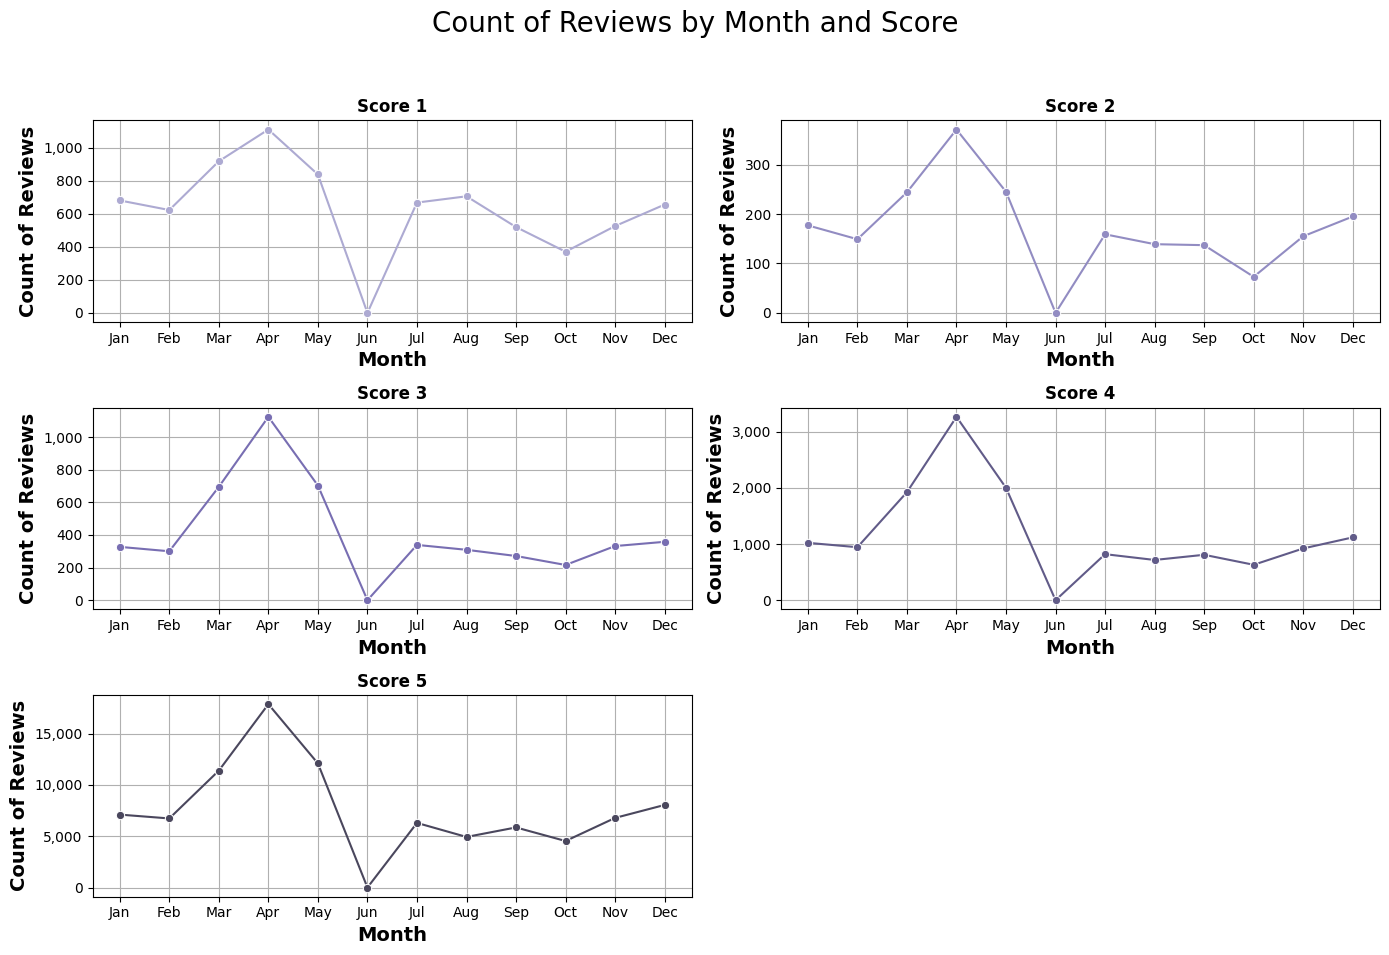

In [34]:


fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Count of Reviews by Month and Score', fontsize=20)

month_score_counts = reviews.groupby(['Month', 'score']).size().reset_index(name='count')
unique_scores = month_score_counts['score'].unique()

# Define a darker grey color palette
dark_grey_palette = sns.color_palette("Purples_d", len(unique_scores))
score_to_color = dict(zip(unique_scores, dark_grey_palette))

# Loop through subplots and plot data
for idx, score in enumerate(unique_scores):
    data_to_plot = month_score_counts[month_score_counts['score'] == score]
    if not data_to_plot.empty:
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]
        sns.lineplot(data=data_to_plot, x='Month', y='count', marker='o', ci=None, ax=ax, color=score_to_color[score])
        ax.set_title(f'Score {score}', fontweight='bold')
        ax.set_xlabel('Month', fontsize=14, fontweight='bold')
        ax.set_ylabel('Count of Reviews', fontsize=14, fontweight='bold')
        ax.grid(True)
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    else:
        pass  # Skip empty subplots

# Hide any remaining empty subplots
for ax in axs.flatten():
    if not ax.lines:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These **Line plots** reveals that:
- Reviews of all scores have a peak in month of **April**.
- Reviews of **score 5** goes beyond **15,000** reviews in **April**.
- Reviews with **score 1** and **score 3** are showing similar pattern in all months.

## Are there any daily trends in the frequency of reviews?

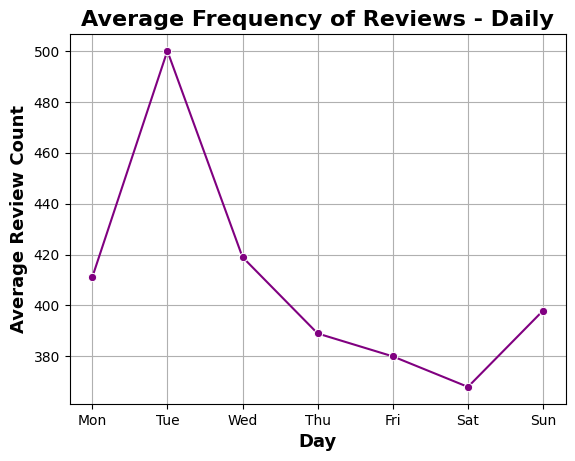

In [35]:
Daily_review_counts = (reviews['Weekday'].value_counts(sort=False)//42).reset_index() # dividing by 42 because we
sns.lineplot(data = Daily_review_counts, x = 'Weekday', y = 'count', marker='o', color = 'Purple')
plt.title('Average Frequency of Reviews - Daily',fontweight = 'bold', fontsize = 16)
plt.xlabel('Day', fontweight = 'bold', fontsize = 13) 
plt.ylabel('Average Review Count', fontweight = 'bold', fontsize = 13) 
plt.grid(True)
plt.show()

This **line plot** expresses that:
- Reviews peak on **Tuesday**, averaging around **440**.
- Review counts decrease from **Tuesday** to **Saturday**, hitting a low around **340**.
- Review frequency slightly rises again on **Sunday**.

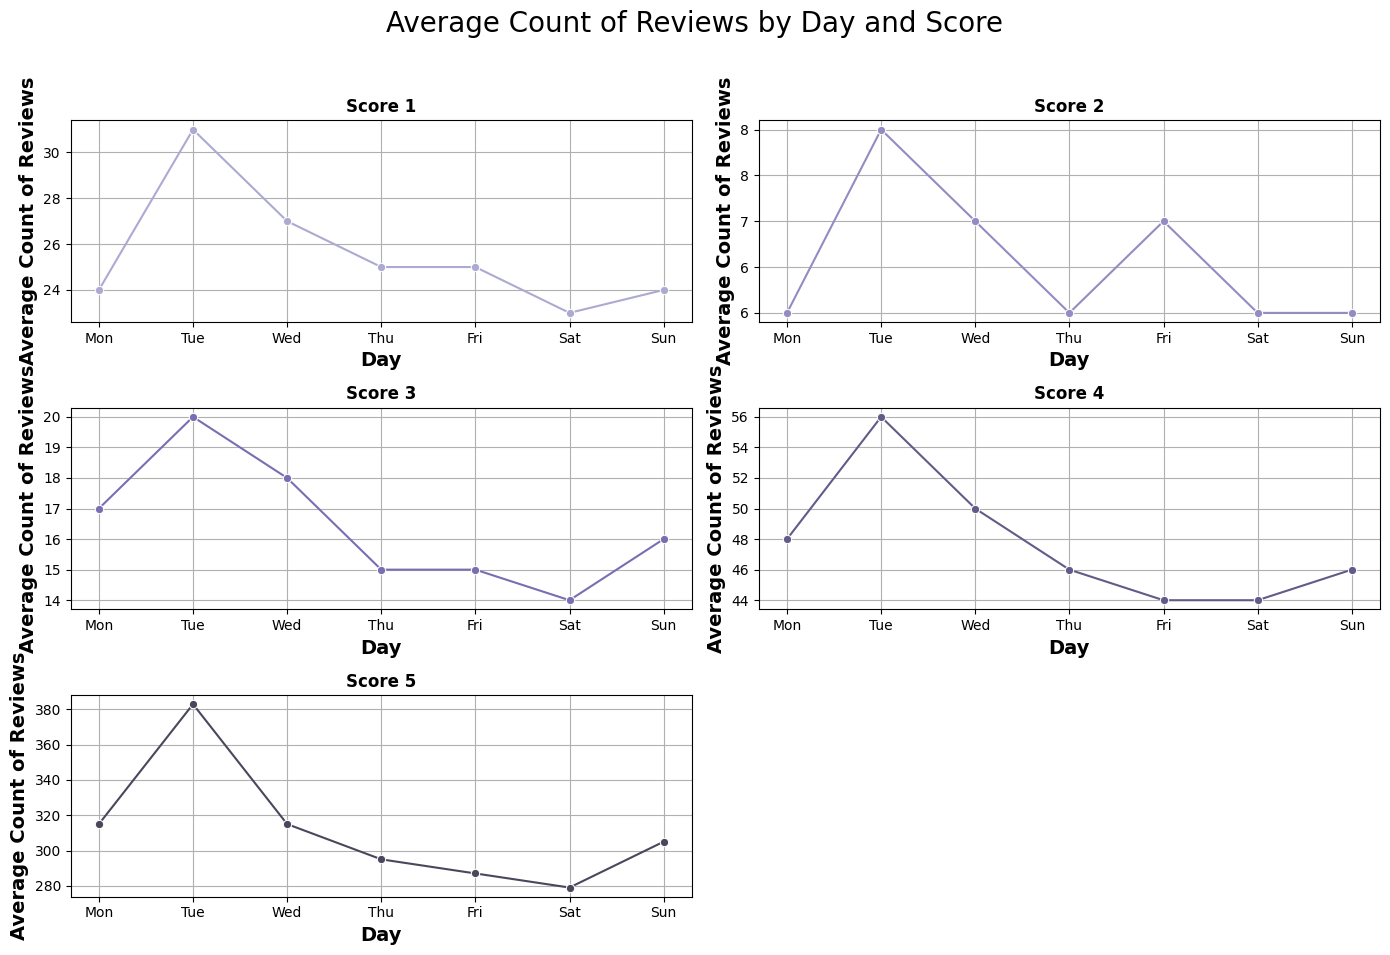

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Average Count of Reviews by Day and Score', fontsize=20)

Day_score_counts = (reviews.groupby(['Weekday', 'score']).size()//42).reset_index(name='count')
unique_scores = Day_score_counts['score'].unique()

# Define a darker grey color palette
dark_grey_palette = sns.color_palette("Purples_d", len(unique_scores))
score_to_color = dict(zip(unique_scores, dark_grey_palette))

# Loop through subplots and plot data
for idx, score in enumerate(unique_scores):
    data_to_plot = Day_score_counts[Day_score_counts['score'] == score]
    if not data_to_plot.empty:
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]
        sns.lineplot(data=data_to_plot, x='Weekday', y='count', marker='o', ci=None, ax=ax, color=score_to_color[score])
        ax.set_title(f'Score {score}', fontweight = 'bold')
        ax.set_xlabel('Day', fontsize=14, fontweight = 'bold')
        ax.set_ylabel('Average Count of Reviews', fontsize=14, fontweight = 'bold')
        ax.grid(True)
        ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    else:
        pass  # Skip empty subplots

# Hide any remaining empty subplots
for ax in axs.flatten():
    if not ax.lines:
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

These **line plots** are showing that:
- Reviews for all scores peak on **Tuesday**.
- Scores **1**, **3**, and **5** see a decline from **Tuesday** to **Saturday**, with slight increases on **Sunday**.
- Scores **2** and **4** show a sharp drop from **Wednesday** to **Friday**, with a slight recovery on **Sunday**.

##  